<a href="https://colab.research.google.com/github/stochasticats/imdb-review-sentiment-classifier/blob/master/imdb_movie_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDb Movie Review Sentiment Classification
This Google colab notebook is for developing a deep learning model to classify movie reviews as positive or negative using the data set provided here http://ai.stanford.edu/~amaas/data/sentiment/

First we establish the libraries to be used.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
import os
import shutil
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2.2.0


First download the zipped data from ai.stanford

In [3]:
!wget "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

--2020-06-01 12:59:24--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  19.1MB/s    in 7.1s    

2020-06-01 12:59:32 (11.3 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
%%capture
!tar -xvf "/content/aclImdb_v1.tar.gz"

Here I establish stopwords, these are words that will add no meaning to the reviews and will be removed.

In [0]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

# Load Data and Data Preprocessing

Let's load the training data, which is conveniently in two folders based on the sentiment classification.

In [0]:
loc = '/content/aclImdb/train/pos'
os.chdir(loc)
filelist = os.listdir()

reviews_pos = []
labels_pos = []

for f in filelist:
  with open (f, "r") as myfile:
    labels_pos.append(1)
    review = myfile.read()
    for word in stopwords:
            token = " " + word + " "
            review = review.replace(token, " ")
            review = review.replace("  ", " ")
    reviews_pos.append(review)

loc = '/content/aclImdb/train/neg'
os.chdir(loc)
filelist = os.listdir()

reviews_neg = []
labels_neg = []

for f in filelist:
  with open (f, "r") as myfile:
    labels_neg.append(0)
    review = myfile.read()
    for word in stopwords:
            token = " " + word + " "
            review = review.replace(token, " ")
            review = review.replace("  ", " ")
    reviews_neg.append(review)

In [8]:
randn = random.randint(0,len(reviews_pos))

print("Length of reviews that are positive:")
print(len(reviews_pos))
print("Example of a positive review:")
print(reviews_pos[randn])
print("The label:")
print(labels_pos[randn])
print("Length of reviews that are negative:")
print(len(reviews_neg))
print("Example of a negative review:")
print(reviews_neg[randn])
print("The label:")
print(labels_neg[randn])

Length of reviews that are positive:
12500
Example of a positive review:
Bo Derek's beauty John Derek's revolutionary direction make film worthwhile. <br /><br />Bo, looking gorgeous ever, recently widowed woman experiencing visitations 'dead' husband (Anthony Quinn). He plan. Bo must procure body young man ghost husband can make transformation spectre back corporeal life. Can find fitting candidate? How will Tony can thing? <br /><br />With Bo's attributes, John's unique direction, Quinn's film presence, and, thanks John, pretty exotic look entire film, movie pleasant viewing.
The label:
1
Length of reviews that are negative:
12500
Example of a negative review:
Oh god, horrible, horrible film. Meant comment state society, just reflection worst worst reality TV. Interstitials hosted Jason Jones Don McKellar obnoxious part, written tone perhaps meant reflexive insightful. Rather, moments mind numbing speak camera dialogue written someone love insulting, condescending speech shoves "mean

We have 25,000 reviews in total, 12,500 positive and 12,500 negative. As we can see, our reviews need some processing for the deep learning model.  We need to take out the digits and special characters.

Here's a function to use to process the data.

In [0]:
import spacy
import re,string,unicodedata

def preprocess(text):
    text = re.sub('<[^>]*>', '',text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text=re.sub('[\W]+',' ',text.lower()) +\
       ' '.join(emoticons).replace('-','')  
    return text

In [0]:
reviews = reviews_pos + reviews_neg
labels = labels_pos + labels_neg

In [0]:
denoised_reviews = []

for review in reviews:
  denoised_reviews.append(preprocess(review))

Let's put it into a single data frame and take a look.

In [0]:
dataframe = pd.DataFrame(
    {'reviews': denoised_reviews,
     'labels': labels,
    })
from sklearn.utils import shuffle
dataframe = shuffle(dataframe).reset_index(drop=True)

In [13]:
dataframe.head(20)

,reviews,labels
0,los angeles tv news reporter jennifer the beau...,1
1,the title sequence shows credits written rain ...,1
2,the matador strange film its main character ju...,1
3,i really wanted like movie location shots most...,0
4,i m idea grand epic american revolutionary war...,0
5,despite rather salacious title light teen dram...,1
6,i heard movie watching vh1 s 100 most metal mo...,1
7,between 1937 1939 twentieth century fox made t...,0
8,the word 1st title ominous meaning viewers fil...,0
9,an unusually straight faced actioner played ca...,1


Let's take a look at the distribution of review length.

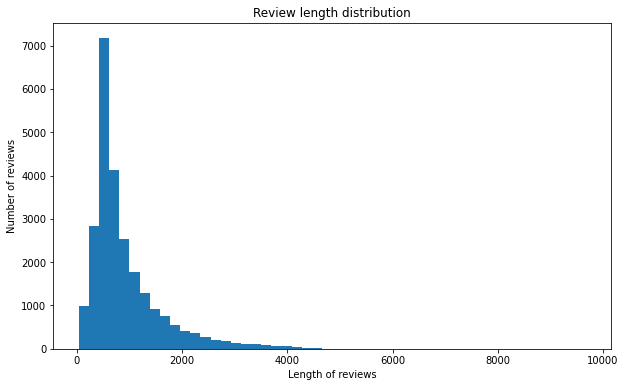

In [14]:
plt.figure(figsize=(10, 6))
plt.hist([len(review) for review in dataframe['reviews']], 50)
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews')
plt.title('Review length distribution')
plt.show()

There seems to be a peak at around length ~1000, meaning there's a lot of reviews with length ~1000. 

In [0]:
vocab_size = 2500
embedding_dim = 64
max_length = 1500
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(dataframe['reviews'], dataframe['labels'], test_size=0.2, random_state=42)

In [18]:
print(len(X_train))
print(len(y_train))
print(len(X_valid))
print(len(y_valid))

20000
20000
5000
5000


In [19]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train_seqs = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seqs, padding=padding_type, maxlen=max_length)

print(len(X_train_seqs[0]))
print(len(X_train_padded[0]))

print(len(X_train_seqs[600]))
print(len(X_train_padded[600]))

print(len(X_train_seqs[10000]))
print(len(X_train_padded[10000]))

281
1500
96
1500
130
1500


In [20]:
X_valid_seqs = tokenizer.texts_to_sequences(X_valid)
X_valid_padded = pad_sequences(X_valid_seqs, padding=padding_type, maxlen=max_length)

print(len(X_valid_seqs))
print(X_valid_padded.shape)

5000
(5000, 1500)


# Deep Learning Model

Here I build the deep learning model. 

First we start with an embedding layer so that the network learns the embedding space our vocabulary lives in. Words or phrases are mapped to vectors of real numbers. The embedding layer is a dimensionality reduction technique used to take the size of vocabulary to a vector space with much lower dimension.

Then the data is fed into dense layers.

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1500, 64)          160000    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 64)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 24)                792       
_________________________________________________________________
dropout_10 (Dropout)         (None, 24)               

Let's set up some callbacks. Callbacks:

**EarlyStopping** - stop early if the validation loss has stopped improving

**ModelCheckpoint** - save the model every epoch and save the best weights

**ReduceLROnPlateau** - reduce learning rate when validation loss has stopped improving

**LearningRateScheduler** - set learning rate to ramp up during early epochs


Learning rate per epoch:


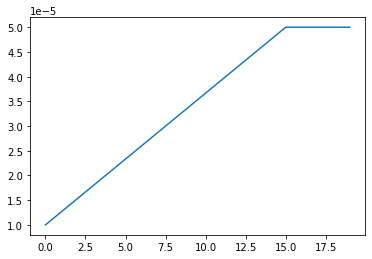

In [44]:
es = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint('model.hdf5', save_best_only=True, verbose=0)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1)

epochs = 20
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 15
sustain_epochs = 10
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return min_lr
    
lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(epochs)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [45]:
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=64, validation_data=(X_valid_padded, y_valid), verbose=1, callbacks=[mc])

Epoch 1/20
313/313 [==============================] - 6s 18ms/step - loss: 0.6930 - accuracy: 0.5112 - val_loss: 0.6926 - val_accuracy: 0.5104
Epoch 2/20
313/313 [==============================] - 5s 17ms/step - loss: 0.6535 - accuracy: 0.5960 - val_loss: 0.4901 - val_accuracy: 0.7728
Epoch 3/20
313/313 [==============================] - 5s 17ms/step - loss: 0.3944 - accuracy: 0.8322 - val_loss: 0.3359 - val_accuracy: 0.8628
Epoch 4/20
313/313 [==============================] - 5s 18ms/step - loss: 0.3201 - accuracy: 0.8747 - val_loss: 0.3275 - val_accuracy: 0.8652
Epoch 5/20
313/313 [==============================] - 5s 17ms/step - loss: 0.2961 - accuracy: 0.8834 - val_loss: 0.2979 - val_accuracy: 0.8780
Epoch 6/20
313/313 [==============================] - 5s 17ms/step - loss: 0.2777 - accuracy: 0.8921 - val_loss: 0.3189 - val_accuracy: 0.8674
Epoch 7/20
313/313 [==============================] - 5s 17ms/step - loss: 0.2701 - accuracy: 0.8954 - val_loss: 0.3051 - val_accuracy: 0.8756

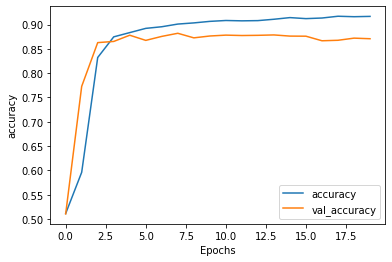

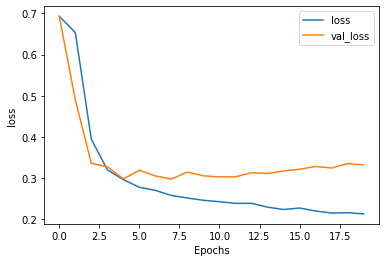

In [46]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [47]:
loc = '/content/aclImdb/test/pos'
os.chdir(loc)
filelist = os.listdir()

test_reviews_pos = []
test_labels_pos = []

for f in filelist:
  with open (f, "r") as myfile:
    test_labels_pos.append(1)
    review = myfile.read()
    for word in stopwords:
            token = " " + word + " "
            review = review.replace(token, " ")
            review = review.replace("  ", " ")
    test_reviews_pos.append(review)

loc = '/content/aclImdb/test/neg'
os.chdir(loc)
filelist = os.listdir()

test_reviews_neg = []
test_labels_neg = []

for f in filelist:
  with open (f, "r") as myfile:
    test_labels_neg.append(0)
    review = myfile.read()
    for word in stopwords:
            token = " " + word + " "
            review = review.replace(token, " ")
            review = review.replace("  ", " ")
    test_reviews_neg.append(review)

UnicodeDecodeError: ignored

In [0]:
test_reviews = test_reviews_pos + test_reviews_neg
test_labels = test_labels_pos + test_labels_neg

denoised_test_reviews = []

for review in test_reviews:
  denoised_test_reviews.append(preprocess(review))

dataframe_test = pd.DataFrame(
    {'reviews': denoised_test_reviews,
     'labels': test_labels,
    })

In [0]:
dataframe_test = shuffle(dataframe_test).reset_index(drop=True)

In [0]:
test_sentences = dataframe_test['reviews']
test_labels = dataframe_test['labels']

In [0]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [48]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

782/782 [==============================] - 3s 4ms/step - loss: 0.3245 - accuracy: 0.8730
Test loss: 0.3245401382446289
Test accuracy: 0.8730400204658508


In [67]:
Review = 'Where to begin? This headliner at the Fecal Film Festival is without a doubt the worst thing I have ever seen. Entirely without any redeeming value whatsoever, not even camp value mind you... this film lacks any substantive plot or story line that is discernable, nor comprehendable dialogue, nor even interest as a soft core porno.' #@param {type:"string"}
Review = preprocess(Review)
Review = tokenizer.texts_to_sequences([Review])
Review = pad_sequences(Review, padding=padding_type, maxlen=max_length)
prediction = model.predict(Review)
print(prediction)

[[0.00656563]]
